In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from types import MethodDescriptorType
#drive.mount('/content/drive/')

#Reading in the data
xqrdata = pd.read_csv('https://raw.githubusercontent.com/paolaUWB/DR16Q/Anna/CROSS_CORRELATION/XQR30_data_assembled_errors_Current.csv')
highZ = pd.read_csv('https://raw.githubusercontent.com/paolaUWB/DR16Q/Anna/CROSS_CORRELATION/highRedshiftQuasarCSV.csv')
xqrdataBS = pd.read_csv('https://raw.githubusercontent.com/paolaUWB/DR16Q/Anna/CROSS_CORRELATION/XQR30_physicalproperties_CIVblueshift_errorincluded.csv')

#Creating arrays with the data
loglbol = np.array(xqrdata["Log_Lbol"])
logbhmciv = np.array(xqrdata["Log_bhm_civ"])
logbhmmgii = np.array(xqrdata["Log_bhm_mgii"])
eddciv = np.array(xqrdata["edd_civ"])
logeddciv = np.log10(eddciv)
eddmgii = np.array(xqrdata["edd_mgii"])
logeddmgii = np.log10(eddmgii)
vmax = np.array(xqrdata["Vmax"])
logvmax = np.log10(vmax)
midZstatus = np.array(xqrdata["status"])


#Separating Quasars by type using the midZstatus column of the csv
midZEHVO = (midZstatus == "EHVO")
midZBAL = (midZstatus == "BAL")
midZnBAL = (midZstatus == "nBAL")
midZunknown = (midZstatus == "N/A")

#midredshift physical properties by status

#EHVO Physical Properties-----------------------------------------------------------
mlbolE = loglbol[midZEHVO]
mbhmE = logbhmciv[midZEHVO]
meddE = logeddciv[midZEHVO]

#BAL Physical Properties-----------------------------------------------------------
mlbolB = loglbol[midZBAL]
mbhmB = logbhmciv[midZBAL]
meddB = logeddciv[midZBAL]

#nBAL Physical Properties-----------------------------------------------------------
mlbolN = loglbol[midZnBAL]
mbhmN = logbhmciv[midZnBAL]
meddN = logeddciv[midZnBAL]

#Extra 12 Physical Properties-----------------------------------------------------------
mlbolU = loglbol[midZunknown]
mbhmU = logbhmciv[midZunknown]
meddU = logeddciv[midZunknown]

#Error Values------------------------------------------------------------------------
mlbolErrminus = np.array(xqrdata['AVGLog_bhm_civ_errminus'])
mlbolErrplus = np.array(xqrdata['AVGLog_bhm_civ_errplus'])
mbhmErrminus = np.array(xqrdata['AVGLog_bhm_civ_errminus'])
mbhmErrplus = np.array(xqrdata['AVGLog_bhm_civ_errplus'])
meddErrminus = np.array(xqrdata['AVGLog_edd_civ_errminus_pos'])
meddErrplus = np.array(xqrdata['AVGLog_edd_civ_errplus'])
civerrplus = np.array(xqrdataBS['AVG_BS_errplus'])
civerrminus = np.array(xqrdataBS['AVG_BS_errplus'])
ReferenceZero = np.array(xqrdata['Reference_Zero'])


In [ ]:
from pandas.core.arrays.arrow.array import Any
# settings
SPACE_BETWEEN_GRAPHS = 0.01
HISTOGRAM_TICKS_ON = False

#fonts
AXIS_FONTSIZE = 16
LEGEND_FONTSIZE = 8

# colors
HIGHZ_IS_EHVO_COLOR = 'purple'
HIGHZ_MAYBE_EHVO_COLOR = 'plum'
HIGHZ_NOT_EHVO_COLOR = 'aqua'

BAL_HIGH_VELOCITY_COLOR = 'aqua'
BAL_LOW_VELOCITY_COLOR = 'cornflowerblue'

# binwidths
VELOCITY_GRAPH_BINWIDTH_X = 0.15

# speed limits in km/s
HIGH_VELOCITY_BAL_MIN = 10_000 # also treated as max velocity for low velocity BALs
HIGH_VELOCITY_BAL_MAX = 25_000

# where images will be saved
images_dir = '/content/drive/MyDrive/Images/'


from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy import stats
from astropy.io import fits
import os
from collections import defaultdict
#change dpi to 200 for the legends to line up and for proper quality
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.labelsize'] = AXIS_FONTSIZE

#If you are trying to add a new csv, or the location of one of these files changed, remember that all you have to do is:
#"copy link address" of the file in GitHub, then paste here in this format: "https://github.com/paolaUWB/DR16Q/blob/branch/folder_name/file_name.csv"
#then just replace "github" with "raw.githubusercontent" and you're good to go.
highZfile = pd.read_csv('https://raw.githubusercontent.com/paolaUWB/DR16Q/Anna/CROSS_CORRELATION/highRedshiftQuasarCSV.csv')

#If you want Rodriguez-Hidalgo data present on the graph, comment out "RH = 'n'", if you don't want it there comment out "RH = 'y'"
RH ='y'
#RH='n'

if RH =='y':
  #reading in csv's from github
  infoRankineparent = 'https://raw.githubusercontent.com/paolaUWB/DR16Q/master/CROSS_CORRELATION/DR16parent_DR14RankineInfo.csv'
  infoRankineEHVO = 'https://raw.githubusercontent.com/paolaUWB/DR16Q/master/CROSS_CORRELATION/DR16EHVO_DR14RankineInfo.csv'

if RH =='y':
  #Extracting values from Rankines info file for EHVO Parent
  dfRPA = pd.read_csv(infoRankineparent, header=None)
  dfRHV = pd.read_csv(infoRankineEHVO, header=None)

  #assigning names to particular columns of the data
  bi_bi = dfRPA[dfRPA.columns[10]].to_numpy()
  bi_vmax = dfRPA[dfRPA.columns[11]].to_numpy()
  bi_vmin = dfRPA[dfRPA.columns[12]].to_numpy()
  SNR = dfRPA[dfRPA.columns[15]].to_numpy()

  #Defining BAL vs Non-BAL with signal to noise ratio and (?)
  non_bal = np.where((bi_bi==0)&(SNR > 10))
  pos_bal = np.where((bi_bi>0) & (SNR > 10))


  highVelocity_bal_Parentin14Rank = np.where((bi_bi > 0) & (SNR > 10) &
    (bi_vmax >= HIGH_VELOCITY_BAL_MIN))
  lowVelocity_bal_Parentin14Rank = np.where((bi_bi > 0) & (SNR > 10) &
    (bi_vmax <= HIGH_VELOCITY_BAL_MIN))

  #for parent sample
  Parentin14Rank_mbh=dfRPA[dfRPA.columns[16]].to_numpy()
  Parentin14Rank_lbol=dfRPA[dfRPA.columns[17]].to_numpy()
  Parentin14Rank_redd=dfRPA[dfRPA.columns[18]].to_numpy()

  #for EHVOs
  EHVOin14Rank_mbh=dfRHV[dfRHV.columns[16]].to_numpy()
  EHVOin14Rank_lbol=dfRHV[dfRHV.columns[17]].to_numpy()
  EHVOin14Rank_redd=dfRHV[dfRHV.columns[18]].to_numpy()

  #Physical properties from data
  MBH_parentR = Parentin14Rank_mbh
  Lbol_parentR = Parentin14Rank_lbol
  Redd_parentR = Parentin14Rank_redd

  #Variables for EHVOs
  MBH_EHVOR = EHVOin14Rank_mbh
  Lbol_EHVOR = EHVOin14Rank_lbol
  Redd_EHVOR = EHVOin14Rank_redd

  #Variables for non BALs
  MBHnonBAL = MBH_parentR[non_bal]
  LbolnonBAL = Lbol_parentR[non_bal]
  ReddnonBAL = Redd_parentR[non_bal]

  #Variables for BALs
  MBHBAL = MBH_parentR[pos_bal]
  LbolBAL = Lbol_parentR[pos_bal]
  ReddBAL = Redd_parentR[pos_bal]

#If you want Rankine data present on the graph, comment out "RH = 'n'", if you don't want it there comment out "RH = 'y'"
Rankine = 'y'
#Rankine = 'n'

if Rankine == 'y':
  #not ideal, working to fix this, but you need to download the file named 'Rankine20_CIV_BAL.fits' and put it in your own google drive in drive > MyDrive > Colab Notebooks
  !touch "/content/Rankine20_CIV_BAL.fits"
  rankineAll = "/content/drive/MyDrive/Colab Notebooks/Rankine20_CIV_BAL.fits"
  rankineall = fits.open(rankineAll)
  data_rankAll = rankineall[1].data
  #print(data_rankAll.columns)
  bi_bi = data_rankAll['BI_BI']
  good = data_rankAll['good']
  bi_vmin = data_rankAll['BI_VMIN']
  bi_vmax = data_rankAll['BI_VMAX']
  bal_rankAll = np.where((bi_bi > 0)&(good == 1))
  highVelocity_bal_rankAll = np.where((bi_bi > 0) & (good == 1) &
    (bi_vmax >= HIGH_VELOCITY_BAL_MIN))
  lowVelocity_bal_rankAll = np.where((bi_bi > 0) & (good == 1) &
    (bi_vmax <= HIGH_VELOCITY_BAL_MIN))

  nonbal_rankAll = np.where((bi_bi == 0)&(good == 1))

  #defining variable names
  eddrat = data_rankAll['LOG_REDD']
  eddrat_bal = eddrat[bal_rankAll]
  eddrat_nbal = eddrat[nonbal_rankAll]
  lbol = data_rankAll['LOG_LBOL']
  lbol_bal = lbol[bal_rankAll]
  lbol_nbal = lbol[nonbal_rankAll]
  bhm = data_rankAll['LOG_BHM_CIV']
  bhm_bal = bhm[bal_rankAll]
  bhm_nbal = bhm[nonbal_rankAll]


def find_log_err (val, err, error_is_positive):
    val_without_error = np.log10(val)
    if error_is_positive:
        val_with_error = np.log10(val + err)
    else:
        val_with_error = np.log10(val - err)

    return np.abs(val_with_error - val_without_error)

#Creating a class for making the scatter histograms
class GraphHandler:
    num_of_graphs = 0

    def __init__(self, left, bottom, width, height, filename="default"):
        rect_scatter = [left, bottom, width, height]
        # what does 0.2 mean in this context? TODO: remove magic number
        rect_histx = [left, bottom + height + SPACE_BETWEEN_GRAPHS, width, 0.2]
        rect_histy = [left + width + SPACE_BETWEEN_GRAPHS, bottom, 0.2, height]

        # this declaration seems redundant but it was in orignal code
        self.fig = plt.figure(1)
        self.fig = plt.figure(figsize=(8,8))

        # define graph boundaries based on dimensions
        self.ax = self.fig.add_axes(rect_scatter)
        self.ax_histx = self.fig.add_axes(rect_histx, sharex = self.ax)
        self.ax_histy = self.fig.add_axes(rect_histy, sharey = self.ax)

        self.x_vals     = []
        self.y_vals     = []
        self.color_vals = []

        #for file naming purposes
        self.filename = filename

    def add_error(self, x, y, xerr, yerr, ecolor='red', capsize=None):
      self.ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='none', linewidth=1.00, ecolor='black', zorder=9, capsize=capsize)


    # TODO: maybe throw an exception if any values out of range?
    def add_point(self, x, y, color, label, size=5, marker = None, addToHistogram = True, edgecolors=None, zorder = 1.0, linewidth=Any, width=Any):
        # find indices of Nan or infinite values, and delete them from input
        idx = [i for i, arr in enumerate(x) if not np.isfinite(arr).all()]
        idy = [i for i, arr in enumerate(y) if not np.isfinite(arr).all()]
        invalidIndices = np.concatenate((idx, idy)).astype(np.signedinteger)

        filteredX = np.delete(x, invalidIndices)
        filteredY = np.delete(y, invalidIndices)

        self.ax.scatter(filteredX, filteredY, s=size, color=color, label=label, marker=marker, edgecolors=edgecolors, zorder=zorder)

        if addToHistogram:
          self.x_vals.append(filteredX)
          self.y_vals.append(filteredY)
          self.color_vals.append(color)

    def set_axes(self, xlabel=None, ylabel=None):
       self.ax.set(xlabel=xlabel, ylabel=ylabel)

    def display_graph(self, MINUS_X_SPACE=0, PLUS_X_SPACE=0, MINUS_Y_SPACE=0,PLUS_Y_SPACE=0,loc="best", bbox_to_anchor=None, BINWIDTH_X=None, BINWIDTH_Y=None):
        # defining tick appearance
        self.ax_histx.tick_params(axis='x', labelbottom=False, labelleft=False, bottom=HISTOGRAM_TICKS_ON)
        self.ax_histy.tick_params(axis='y', labelbottom=False, labelleft=False, left=HISTOGRAM_TICKS_ON)

        # defining x/y limits
        ymin, ymax = min(map(min, self.y_vals)), max(map(max, self.y_vals))
        xmin, xmax = min(map(min, self.x_vals)), max(map(max, self.x_vals))

        self.ax.set_ylim(ymin - MINUS_Y_SPACE, ymax + PLUS_Y_SPACE)
        #self.ax.set_xlim(xmin - MINUS_X_SPACE, xmax + MINUS_X_SPACE) # PRH: I found a typo here, it should be PLUS_X_SPACE
        self.ax.set_xlim(xmin - MINUS_X_SPACE, xmax + PLUS_X_SPACE) # PRH: I found a typo here, it should be PLUS_X_SPACE


        all_binwidth_x = []
        all_binwidth_y = []
        # find binwidth
        for x, y in zip(self.x_vals, self.y_vals):
          if len(x) <= 3:
            continue
          tmp_x = stats.knuth_bin_width(x)
          tmp_y = stats.knuth_bin_width(y)
          if np.isfinite(tmp_x) and np.isfinite(tmp_y):
            all_binwidth_x.append(stats.knuth_bin_width(x))
            all_binwidth_y.append(stats.knuth_bin_width(y))

        if BINWIDTH_X == None:
          binwidth_x = np.mean(all_binwidth_x)
        else:
          binwidth_x = BINWIDTH_X
        if BINWIDTH_Y == None:
          binwidth_y = np.mean(all_binwidth_y)
        else:
          binwidth_y = BINWIDTH_Y

        binsx = np.arange(xmin - MINUS_X_SPACE, xmax + PLUS_X_SPACE, binwidth_x)
        binsy = np.arange(ymin - MINUS_Y_SPACE, ymax + PLUS_Y_SPACE, binwidth_y)

        # iterate through all stored data to build histogram
        for x, y, color in zip(self.x_vals, self.y_vals, self.color_vals):
            weightsx = [np.ones_like(x)/float(len(x))]
            weightsy = [np.ones_like(y)/float(len(y))]

            # TODO: remove magic number
            self.ax_histx.hist(x, bins=binsx, weights=weightsx, color=color, alpha=0.5)
            self.ax_histy.hist(y, bins=binsy, weights=weightsy, orientation='horizontal', color=color, alpha=0.5)

#        self.ax_histx.set_xticklabels([])
#        self.ax_histy.set_xticklabels([])

#        self.ax_histx.set_yticklabels([])
#        self.ax_histy.set_yticklabels([])


        # put finishing touches and display everything
        # TODO: set up legend config settings
        self.ax.legend(loc=loc, fontsize=LEGEND_FONTSIZE, bbox_to_anchor=bbox_to_anchor)
        !mkdir "{images_dir}"
        plt.savefig(f"{images_dir}/{self.filename}.png", bbox_inches='tight')
        GraphHandler.num_of_graphs += 1
        plt.show()




# defining high-z parameters
highZmass = defaultdict(list)
highZedd = defaultdict(list)
highZbol_lum = defaultdict(list)
highZmassErr = defaultdict(list)
highZeddErr  = defaultdict(list)
highZbolErr = defaultdict(list)
highZcolor = dict(Y = HIGHZ_IS_EHVO_COLOR, M = HIGHZ_MAYBE_EHVO_COLOR, N = HIGHZ_NOT_EHVO_COLOR)
highZlabel = dict(Y = 'z>7.0 EHVO QSOs', M = 'z>7.0 Potential EHVO QSOs', N = 'z>7.0 non BALQSOs')

EHVO_STATUS = ['N', 'Y', 'M'] #PRH: I reorder this to follow the same order as non-BALQSOs and EHVOs


for status in EHVO_STATUS:
  dfTemp = highZfile[highZfile['Is_EHVO'] == status]
  highZmass[status] = np.array( dfTemp["bhm"] )
  highZedd[status] = np.array( dfTemp["edd_ratio"] )
  highZbol_lum[status] = np.array( dfTemp["bol_lum"] )
  highZmassErr[status] = np.vstack( (dfTemp["bhm_err_minus"], dfTemp["bhm_err_plus"]) )
  highZeddErr[status] = np.vstack( (dfTemp["edd_ratio_err_minus"], dfTemp["edd_ratio_err_plus"]) )
  highZbolErr[status] = np.vstack( ( dfTemp["bol_lum_err_minus"], dfTemp["bol_lum_err_plus"] ) )

  # calculate the errors
  highZmassErr[status][0] = find_log_err(highZmass[status], highZmassErr[status][0], False)
  highZmassErr[status][1] = find_log_err(highZmass[status], highZmassErr[status][1], True)
  highZeddErr[status][0] = find_log_err(highZedd[status], highZeddErr[status][0], False)
  highZeddErr[status][1] = find_log_err(highZedd[status], highZeddErr[status][1], True)
  highZbolErr[status][0] = find_log_err(highZbol_lum[status], highZbolErr[status][0], False)
  highZbolErr[status][1] = find_log_err(highZbol_lum[status], highZbolErr[status][1], True)
  # take logs for logarithmic graph
  highZmass[status] = np.log10(highZmass[status])
  highZedd[status] = np.log10(highZedd[status])
  highZbol_lum[status] = np.log10(highZbol_lum[status])

print(highZbolErr)



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defaultdict(<class 'list'>, {'N': array([[0.        , 0.0435696 , 0.03476211],
       [0.        , 0.03959436, 0.03218468]]), 'Y': array([[0.03218468, 0.        ],
       [0.02996322, 0.        ]]), 'M': array([[0.0234811 , 0.03218468],
       [0.02227639, 0.02996322]])})


<ipython-input-13-4e1bee71a85d>:179: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  invalidIndices = np.concatenate((idx, idy)).astype(np.signedinteger)


mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

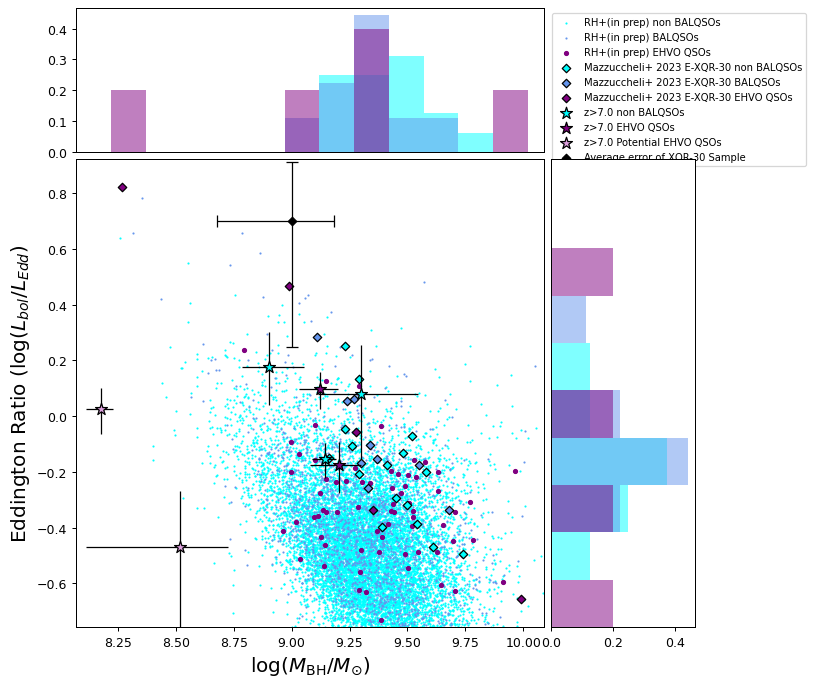

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

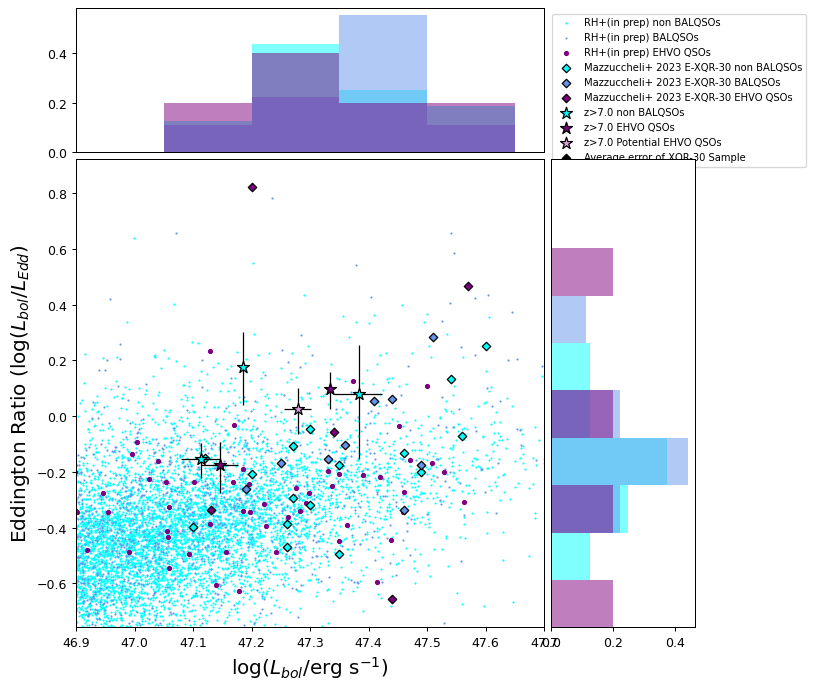

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

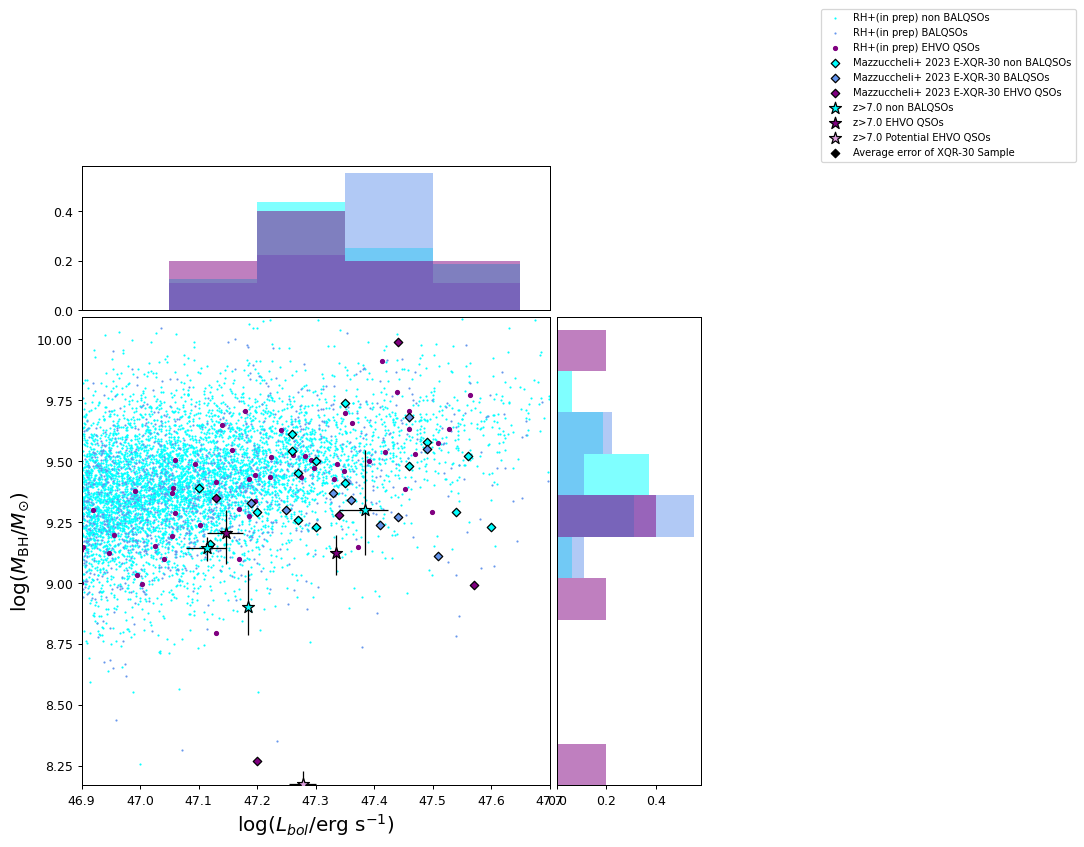

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

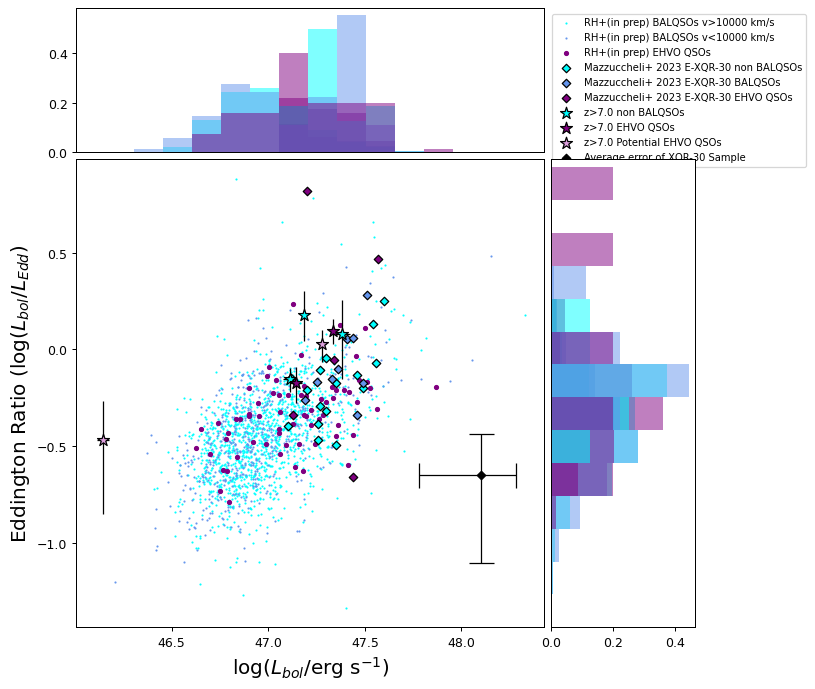

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

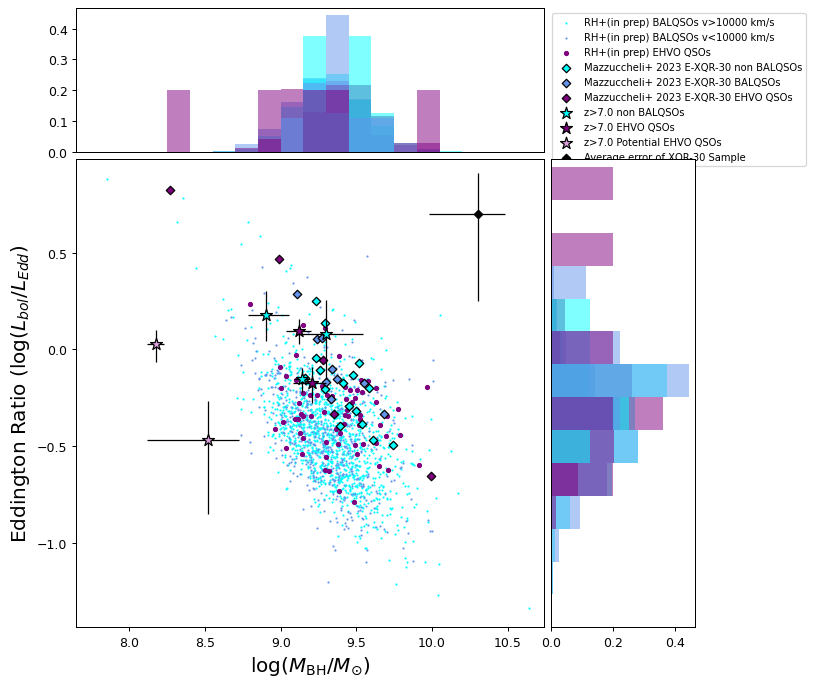

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

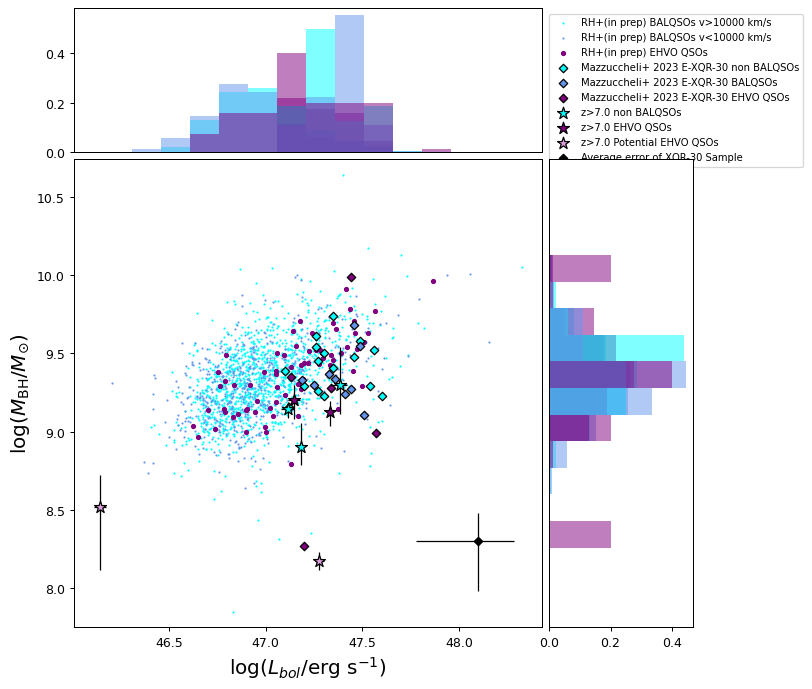

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

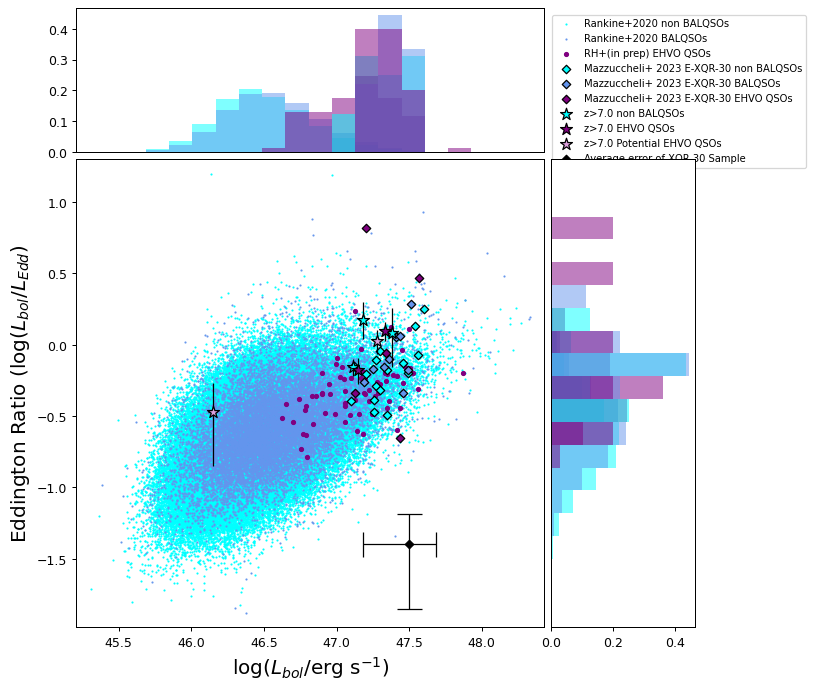

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

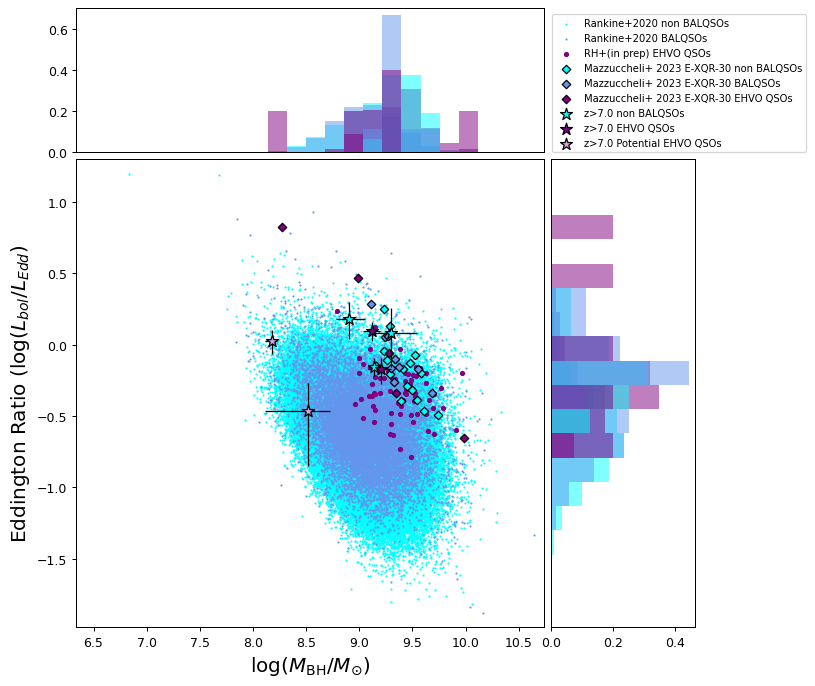

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

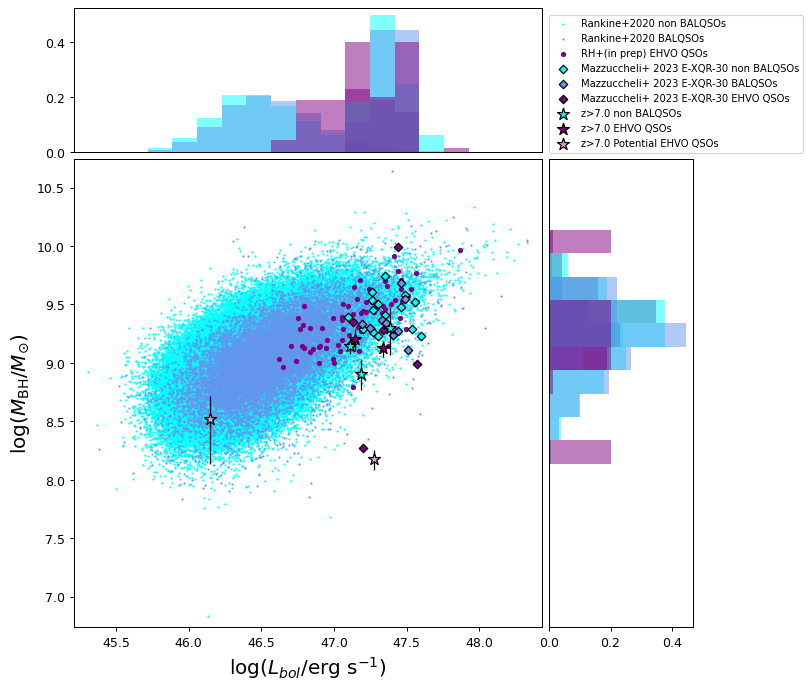

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

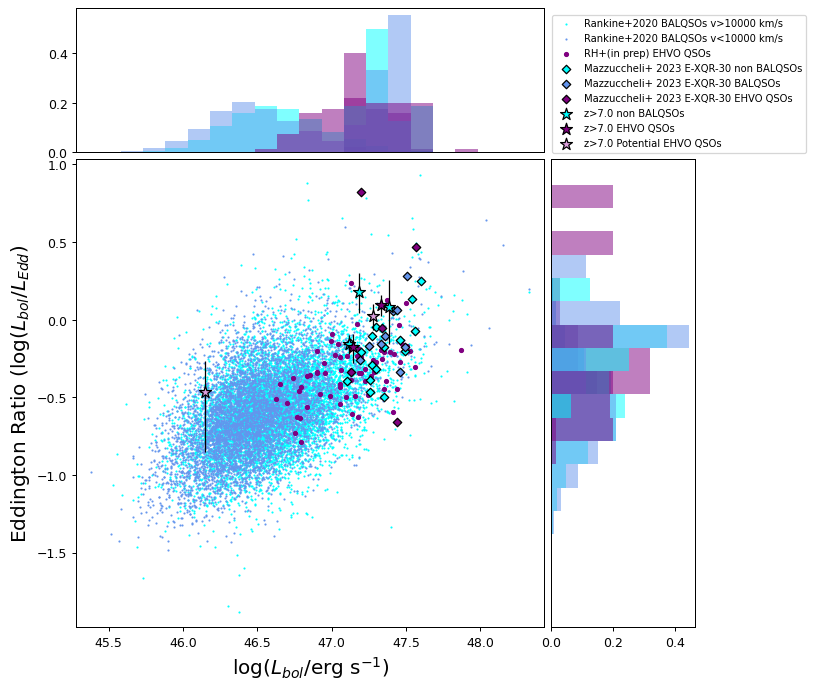

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

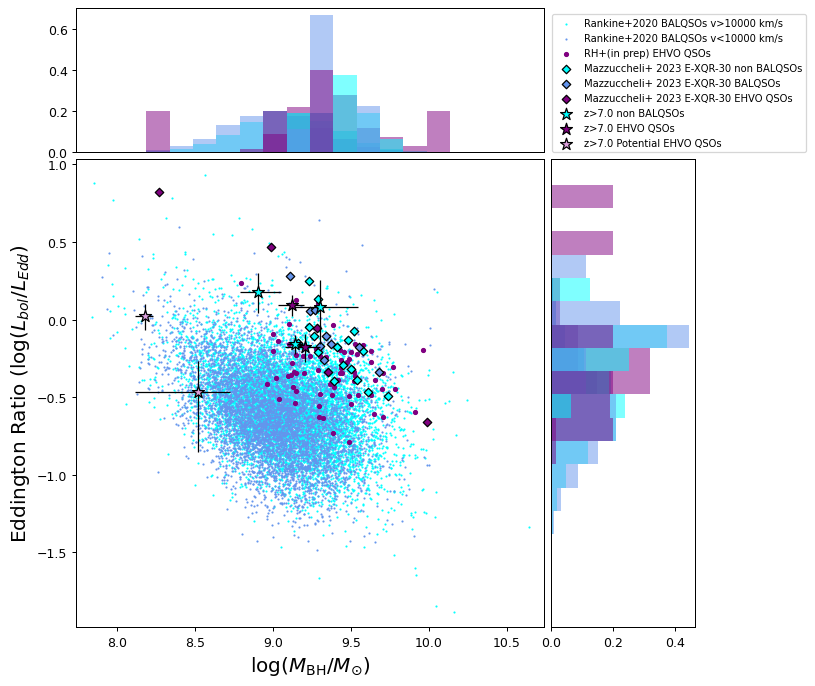

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

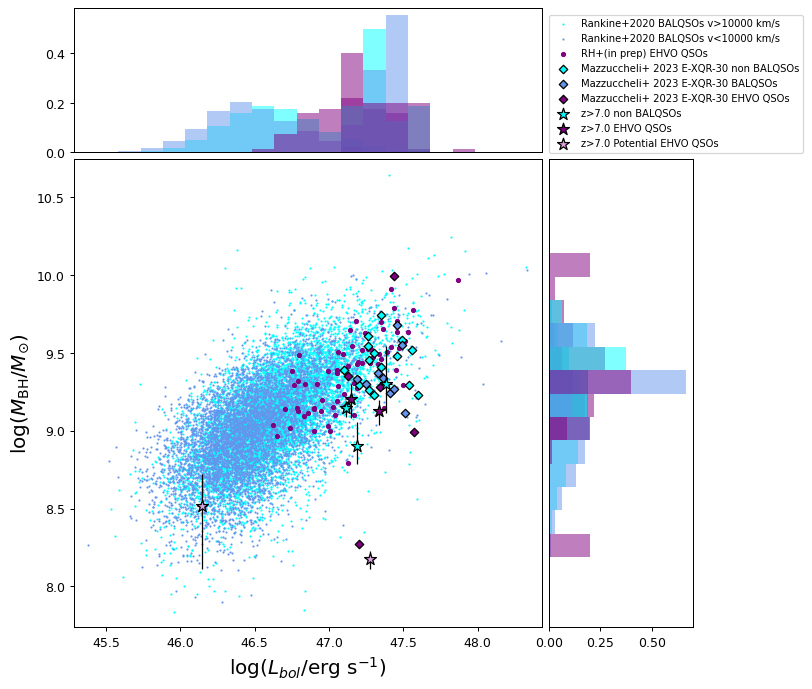

In [ ]:
#Parent Data, High Redshift Quasars, and Mid Redshift Quasars I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I
bhm_vs_eddratio = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_MBH_Parent_zmid")
bhm_vs_eddratio.set_axes(xlabel="log($M_{\mathrm{BH}}/M_{\odot})$", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

if RH == 'y':
  bhm_vs_eddratio.add_point(MBHnonBAL, ReddnonBAL, 'aqua', 'RH+(in prep) non BALQSOs', size = 0.5, addToHistogram=False)
  bhm_vs_eddratio.add_point(MBHBAL, ReddBAL, 'cornflowerblue', 'RH+(in prep) BALQSOs', size = 0.5, addToHistogram=False)
  bhm_vs_eddratio.add_point(MBH_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10, addToHistogram=False)
bhm_vs_eddratio.add_point(mbhmN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
bhm_vs_eddratio.add_point(mbhmB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
bhm_vs_eddratio.add_point(mbhmE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')


for status in EHVO_STATUS:
  bhm_vs_eddratio.add_point(highZmass[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
  bhm_vs_eddratio.add_error(highZmass[status], highZedd[status], highZmassErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
bhm_vs_eddratio.add_error(ReferenceZero+9, ReferenceZero+0.7, xerr=[mbhmErrminus, mbhmErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize=5)
bhm_vs_eddratio.add_point(ReferenceZero+9, ReferenceZero+0.7, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

if RH == 'y':
  bhm_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.3223))
if RH == 'n':
  bhm_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.12)


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lbol_vs_eddratio = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_Lbol_Parent_zmid")
lbol_vs_eddratio.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

if RH == 'y':
  lbol_vs_eddratio.add_point(LbolnonBAL, ReddnonBAL, 'aqua', 'RH+(in prep) non BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_eddratio.add_point(LbolBAL, ReddBAL, 'cornflowerblue', 'RH+(in prep) BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_eddratio.add_point(Lbol_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10, addToHistogram=False)
lbol_vs_eddratio.add_point(mlbolN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_eddratio.add_point(mlbolB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_eddratio.add_point(mlbolE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

for status in EHVO_STATUS:
  lbol_vs_eddratio.add_point(highZbol_lum[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
  lbol_vs_eddratio.add_error(highZbol_lum[status], highZedd[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
lbol_vs_eddratio.add_error(ReferenceZero+48.1, ReferenceZero-0.95, xerr=[mlbolErrminus, mlbolErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize=5)
lbol_vs_eddratio.add_point(ReferenceZero+48.1, ReferenceZero-0.95, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

if RH == 'y':
  lbol_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.3223))
if RH == 'n':
  lbol_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1,  BINWIDTH_X = 0.05, BINWIDTH_Y=0.12)

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lbol_vs_bhm = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "MBH_vs_Lbol_Parent_zmid")
lbol_vs_bhm.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="log($M_{\mathrm{BH}}/M_{\odot})$")

if RH == 'y':
  lbol_vs_bhm.add_point(LbolnonBAL, MBHnonBAL, 'aqua', 'RH+(in prep) non BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_bhm.add_point(LbolBAL, MBHBAL, 'cornflowerblue', 'RH+(in prep) BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_bhm.add_point(Lbol_EHVOR, MBH_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10, addToHistogram=False)
lbol_vs_bhm.add_point(mlbolN, mbhmN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_bhm.add_point(mlbolB, mbhmB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_bhm.add_point(mlbolE, mbhmE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

for status in EHVO_STATUS:
  lbol_vs_bhm.add_point(highZbol_lum[status], highZmass[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
  lbol_vs_bhm.add_error(highZbol_lum[status], highZmass[status], highZbolErr[status], highZmassErr[status], ecolor=highZcolor[status])

#Average Error Point
lbol_vs_bhm.add_error(ReferenceZero+48.1, ReferenceZero+8.3, xerr=[mlbolErrminus, mlbolErrplus], yerr=[mbhmErrminus, mbhmErrplus], ecolor='red', capsize=5)
lbol_vs_bhm.add_point(ReferenceZero+48.1, ReferenceZero+8.3, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

if RH == 'y':
  lbol_vs_bhm.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.3223))
if RH == 'n':
  lbol_vs_bhm.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.2, PLUS_Y_SPACE=0.1,  BINWIDTH_X = 0.05, BINWIDTH_Y=0.14,bbox_to_anchor=(1.57, 1.23))



#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
if RH == 'y':
  #Only outflows figures, with BALs at two speeds Parents II II II II II II II II II II II II II II II II II II II II II II II II II II II II
  lbol_vs_eddratioRSPEED = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_Lbol_Parent_zmid_BALQSO_v10000")
  lbol_vs_eddratioRSPEED.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

  if RH == 'y':
    lbol_vs_eddratioRSPEED.add_point(Parentin14Rank_lbol[highVelocity_bal_Parentin14Rank], Parentin14Rank_redd[highVelocity_bal_Parentin14Rank], BAL_HIGH_VELOCITY_COLOR, 'RH+(in prep) BALQSOs ' + 'v>'+str(HIGH_VELOCITY_BAL_MIN)+' km/s', size=0.5)
    lbol_vs_eddratioRSPEED.add_point(Parentin14Rank_lbol[lowVelocity_bal_Parentin14Rank], Parentin14Rank_redd[lowVelocity_bal_Parentin14Rank], BAL_LOW_VELOCITY_COLOR, 'RH+(in prep) BALQSOs ' + 'v<'+str(HIGH_VELOCITY_BAL_MIN)+' km/s', size=0.5)
    lbol_vs_eddratioRSPEED.add_point(Lbol_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  lbol_vs_eddratioRSPEED.add_point(mlbolN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_eddratioRSPEED.add_point(mlbolB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_eddratioRSPEED.add_point(mlbolE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    lbol_vs_eddratioRSPEED.add_point(highZbol_lum[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    lbol_vs_eddratioRSPEED.add_error(highZbol_lum[status], highZedd[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  lbol_vs_eddratioRSPEED.add_error(ReferenceZero+48.1, ReferenceZero-0.65, xerr=[mlbolErrminus, mlbolErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize= 10)
  lbol_vs_eddratioRSPEED.add_point(ReferenceZero+48.1, ReferenceZero-0.65, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  if RH == 'y':
    lbol_vs_eddratioRSPEED.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.3223))
  if RH == 'n':
    lbol_vs_eddratioRSPEED.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, loc='upper right')



#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

  bhm_vs_eddratioRSPEED = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_MBH_Parent_zmid_BALQSO_v10000")
  bhm_vs_eddratioRSPEED.set_axes(xlabel="log($M_{\mathrm{BH}}/M_{\odot})$", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

  if RH == 'y':
    bhm_vs_eddratioRSPEED.add_point(Parentin14Rank_mbh[highVelocity_bal_Parentin14Rank], Parentin14Rank_redd[highVelocity_bal_Parentin14Rank], BAL_HIGH_VELOCITY_COLOR, 'RH+(in prep) BALQSOs ' + 'v>'+str(HIGH_VELOCITY_BAL_MIN)+' km/s', size = 0.5)
    bhm_vs_eddratioRSPEED.add_point(Parentin14Rank_mbh[lowVelocity_bal_Parentin14Rank], Parentin14Rank_redd[lowVelocity_bal_Parentin14Rank], BAL_LOW_VELOCITY_COLOR, 'RH+(in prep) BALQSOs ' + 'v<'+str(HIGH_VELOCITY_BAL_MIN)+' km/s', size = 0.5)
    bhm_vs_eddratioRSPEED.add_point(MBH_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  bhm_vs_eddratioRSPEED.add_point(mbhmN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  bhm_vs_eddratioRSPEED.add_point(mbhmB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  bhm_vs_eddratioRSPEED.add_point(mbhmE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    bhm_vs_eddratioRSPEED.add_point(highZmass[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
    bhm_vs_eddratioRSPEED.add_error(highZmass[status], highZedd[status], highZmassErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  bhm_vs_eddratioRSPEED.add_error(ReferenceZero+10.3, ReferenceZero+0.7, xerr=[mbhmErrminus, mbhmErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red')
  bhm_vs_eddratioRSPEED.add_point(ReferenceZero+10.3, ReferenceZero+0.7, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  if RH == 'y':
    bhm_vs_eddratioRSPEED.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.3223))
  if RH == 'n':
    bhm_vs_eddratioRSPEED.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17)



#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  lbol_vs_bhmRSPEED = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "MBH_vs_Lbol_Parent_zmid_BALQSO_v10000")
  lbol_vs_bhmRSPEED.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="log($M_{\mathrm{BH}}/M_{\odot})$")

  if RH == 'y':
    lbol_vs_bhmRSPEED.add_point(Parentin14Rank_lbol[highVelocity_bal_Parentin14Rank], Parentin14Rank_mbh[highVelocity_bal_Parentin14Rank], BAL_HIGH_VELOCITY_COLOR, 'RH+(in prep) BALQSOs ' + 'v>'+str(HIGH_VELOCITY_BAL_MIN)+' km/s', size=0.5)
    lbol_vs_bhmRSPEED.add_point(Parentin14Rank_lbol[lowVelocity_bal_Parentin14Rank], Parentin14Rank_mbh[lowVelocity_bal_Parentin14Rank], BAL_LOW_VELOCITY_COLOR, 'RH+(in prep) BALQSOs ' + 'v<'+str(HIGH_VELOCITY_BAL_MIN)+' km/s', size=0.5)
    lbol_vs_bhmRSPEED.add_point(Lbol_EHVOR, MBH_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  lbol_vs_bhmRSPEED.add_point(mlbolN, mbhmN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_bhmRSPEED.add_point(mlbolB, mbhmB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_bhmRSPEED.add_point(mlbolE, mbhmE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    lbol_vs_bhmRSPEED.add_point(highZbol_lum[status], highZmass[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    lbol_vs_bhmRSPEED.add_error(highZbol_lum[status], highZmass[status], highZbolErr[status], highZmassErr[status], ecolor=highZcolor[status])

#Average Error Point
  lbol_vs_bhmRSPEED.add_error(ReferenceZero+48.1, ReferenceZero+8.3, xerr=[mlbolErrminus, mlbolErrplus], yerr=[mbhmErrminus, mbhmErrplus], ecolor='red')
  lbol_vs_bhmRSPEED.add_point(ReferenceZero+48.1, ReferenceZero+8.3, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  if RH == 'y':
    lbol_vs_bhmRSPEED.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.3223))
  if RH == 'n':
    lbol_vs_bhmRSPEED.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, loc='lower right')



#----------------------------------------------RANKINE!!!!!!!!!------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
if Rankine == 'y':
#Rankine Data, High Redshift Quasars, and Mid Redshift Quasars III III III III III III III III III III III III III III III III III III III
  lbol_vs_eddratioRank = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_Lbol_Rankine_zmid")
  lbol_vs_eddratioRank.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

  lbol_vs_eddratioRank.add_point(lbol_nbal, eddrat_nbal, 'aqua', 'Rankine+2020 non BALQSOs', size=0.5)
  lbol_vs_eddratioRank.add_point(lbol_bal, eddrat_bal, 'cornflowerblue', 'Rankine+2020 BALQSOs', size=0.5)
  lbol_vs_eddratioRank.add_point(Lbol_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  lbol_vs_eddratioRank.add_point(mlbolN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_eddratioRank.add_point(mlbolB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_eddratioRank.add_point(mlbolE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    lbol_vs_eddratioRank.add_point(highZbol_lum[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    lbol_vs_eddratioRank.add_error(highZbol_lum[status], highZedd[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  lbol_vs_eddratioRank.add_error(ReferenceZero+47.5, ReferenceZero-1.4, xerr=[mlbolErrminus, mlbolErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize=10)
  lbol_vs_eddratioRank.add_point(ReferenceZero+47.5, ReferenceZero-1.4, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  lbol_vs_eddratioRank.display_graph(MINUS_X_SPACE=0.1, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X=0.16, BINWIDTH_Y=0.16, bbox_to_anchor=(1.57, 1.32))

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  bhm_vs_eddratioRank = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_MBH_Rankine_zmid")
  bhm_vs_eddratioRank.set_axes(xlabel="log($M_{\mathrm{BH}}/M_{\odot})$", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

  bhm_vs_eddratioRank.add_point(bhm_nbal, eddrat_nbal, 'aqua', 'Rankine+2020 non BALQSOs', size=0.5)
  bhm_vs_eddratioRank.add_point(bhm_bal, eddrat_bal, 'cornflowerblue', 'Rankine+2020 BALQSOs', size=0.5)
  bhm_vs_eddratioRank.add_point(MBH_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  bhm_vs_eddratioRank.add_point(mbhmN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  bhm_vs_eddratioRank.add_point(mbhmB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  bhm_vs_eddratioRank.add_point(mbhmE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size =23, edgecolors='black')

  for status in EHVO_STATUS:
    bhm_vs_eddratioRank.add_point(highZmass[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    bhm_vs_eddratioRank.add_error(highZmass[status], highZedd[status], highZmassErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  #bhm_vs_eddratioRank.add_error(ReferenceZero+7, ReferenceZero-1.2, xerr=[mbhmErrminus, mbhmErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red')
  #bhm_vs_eddratioRank.add_point(ReferenceZero+7, ReferenceZero-1.2, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  bhm_vs_eddratioRank.display_graph(MINUS_X_SPACE=0.5, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X=0.18, BINWIDTH_Y=0.17, bbox_to_anchor=(1.57, 1.32))

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  lbol_vs_bhmRank = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "MBH_vs_Lbol_Rankine_zmid")
  lbol_vs_bhmRank.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="log($M_{\mathrm{BH}}/M_{\odot})$")

  lbol_vs_bhmRank.add_point(lbol_nbal, bhm_nbal, 'aqua', 'Rankine+2020 non BALQSOs', size = 0.5)
  lbol_vs_bhmRank.add_point(lbol_bal, bhm_bal, 'cornflowerblue', 'Rankine+2020 BALQSOs', size = 0.5)
  lbol_vs_bhmRank.add_point(Lbol_EHVOR, MBH_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  lbol_vs_bhmRank.add_point(mlbolN, mbhmN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_bhmRank.add_point(mlbolB, mbhmB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_bhmRank.add_point(mlbolE, mbhmE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    lbol_vs_bhmRank.add_point(highZbol_lum[status], highZmass[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    lbol_vs_bhmRank.add_error(highZbol_lum[status], highZmass[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  #lbol_vs_bhmRank.add_error(ReferenceZero+48.0, ReferenceZero+7.3, xerr=[mlbolErrminus, mlbolErrplus], yerr=[mbhmErrminus, mbhmErrplus], ecolor='red')
  #lbol_vs_bhmRank.add_point(ReferenceZero+48.0, ReferenceZero+7.3, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  lbol_vs_bhmRank.display_graph(MINUS_X_SPACE=0.1, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X=0.17, BINWIDTH_Y=0.2, bbox_to_anchor=(1.57, 1.32))

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #Only outflows figures, with BALs at two speeds Rankine IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV IV
  lbol_vs_eddratioPSPEED = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_Lbol_Rankine_zmid_BALQSO_v10000")
  lbol_vs_eddratioPSPEED.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

  lbol_vs_eddratioPSPEED.add_point(lbol[highVelocity_bal_rankAll], eddrat[highVelocity_bal_rankAll], BAL_HIGH_VELOCITY_COLOR, 'Rankine+2020 BALQSOs '+'v>'+str(HIGH_VELOCITY_BAL_MIN) + ' km/s', size=0.5)
  lbol_vs_eddratioPSPEED.add_point(lbol[lowVelocity_bal_rankAll], eddrat[lowVelocity_bal_rankAll], BAL_LOW_VELOCITY_COLOR, 'Rankine+2020 BALQSOs '+'v<'+str(HIGH_VELOCITY_BAL_MIN) + ' km/s', size=0.5)
  lbol_vs_eddratioPSPEED.add_point(Lbol_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  lbol_vs_eddratioPSPEED.add_point(mlbolN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_eddratioPSPEED.add_point(mlbolB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_eddratioPSPEED.add_point(mlbolE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    lbol_vs_eddratioPSPEED.add_point(highZbol_lum[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    lbol_vs_eddratioPSPEED.add_error(highZbol_lum[status], highZedd[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  #lbol_vs_eddratioPSPEED.add_error(ReferenceZero+48.1, ReferenceZero-1.1, xerr=[mlbolErrminus, mlbolErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red')
  #lbol_vs_eddratioPSPEED.add_point(ReferenceZero+48.1, ReferenceZero-1.1, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  lbol_vs_eddratioPSPEED.display_graph(MINUS_X_SPACE=0.1, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1,PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.15, bbox_to_anchor=(1.57, 1.32))

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  bhm_vs_eddratioPSPEED = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_MBH_Rankine_zmid_BALQSO_v10000")
  bhm_vs_eddratioPSPEED.set_axes(xlabel="log($M_{\mathrm{BH}}/M_{\odot})$", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)") #PRH: How can you make the labels larger in this framework?

  bhm_vs_eddratioPSPEED.add_point(bhm[highVelocity_bal_rankAll], eddrat[highVelocity_bal_rankAll], BAL_HIGH_VELOCITY_COLOR, 'Rankine+2020 BALQSOs '+'v>'+str(HIGH_VELOCITY_BAL_MIN) + ' km/s', size = 0.5)
  bhm_vs_eddratioPSPEED.add_point(bhm[lowVelocity_bal_rankAll], eddrat[lowVelocity_bal_rankAll], BAL_LOW_VELOCITY_COLOR, 'Rankine+2020 BALQSOs '+'v<'+str(HIGH_VELOCITY_BAL_MIN) + ' km/s', size = 0.5)
  bhm_vs_eddratioPSPEED.add_point(MBH_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  bhm_vs_eddratioPSPEED.add_point(mbhmN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  bhm_vs_eddratioPSPEED.add_point(mbhmB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  bhm_vs_eddratioPSPEED.add_point(mbhmE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    bhm_vs_eddratioPSPEED.add_point(highZmass[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
    bhm_vs_eddratioPSPEED.add_error(highZmass[status], highZedd[status], highZmassErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
  #bhm_vs_eddratioPSPEED.add_error(ReferenceZero+10.4, ReferenceZero+0.7, xerr=[mbhmErrminus, mbhmErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red')
  #bhm_vs_eddratioPSPEED.add_point(ReferenceZero+10.4, ReferenceZero+0.7, 'black', 'Average error of XQR-30 Sample', marker='D', size = 20, addToHistogram=False, zorder=0.1)

  bhm_vs_eddratioPSPEED.display_graph(MINUS_X_SPACE=0.1, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = 0.15, BINWIDTH_Y=0.15, bbox_to_anchor=(1.57, 1.32))

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  lbol_vs_bhmPSPEED = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "MBH_vs_Lbol_Rankine_zmid_BALQSO_v10000")
  lbol_vs_bhmPSPEED.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="log($M_{\mathrm{BH}}/M_{\odot})$")

  lbol_vs_bhmPSPEED.add_point(lbol[highVelocity_bal_rankAll], bhm[highVelocity_bal_rankAll], BAL_HIGH_VELOCITY_COLOR, 'Rankine+2020 BALQSOs '+'v>'+str(HIGH_VELOCITY_BAL_MIN) + ' km/s', size=0.5)
  lbol_vs_bhmPSPEED.add_point(lbol[lowVelocity_bal_rankAll], bhm[lowVelocity_bal_rankAll], BAL_LOW_VELOCITY_COLOR, 'Rankine+2020 BALQSOs '+'v<'+str(HIGH_VELOCITY_BAL_MIN) + ' km/s', size=0.5)
  lbol_vs_bhmPSPEED.add_point(Lbol_EHVOR, MBH_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10)
  lbol_vs_bhmPSPEED.add_point(mlbolN, mbhmN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_bhmPSPEED.add_point(mlbolB, mbhmB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
  lbol_vs_bhmPSPEED.add_point(mlbolE, mbhmE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

  for status in EHVO_STATUS:
    lbol_vs_bhmPSPEED.add_point(highZbol_lum[status], highZmass[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10.0)
    lbol_vs_bhmPSPEED.add_error(highZbol_lum[status], highZmass[status], highZbolErr[status], highZmassErr[status], ecolor=highZcolor[status])

#Average Error Point
  #lbol_vs_bhmPSPEED.add_error(ReferenceZero+48.1, ReferenceZero+8.2, xerr=[mlbolErrminus, mlbolErrplus], yerr=[mbhmErrminus, mbhmErrplus], ecolor='red')
  #lbol_vs_bhmPSPEED.add_point(ReferenceZero+48.1, ReferenceZero+8.2, 'black', 'Average error of XQR-30 Sample', marker='D', size = 23, addToHistogram=False, zorder=0.1)

  lbol_vs_bhmPSPEED.display_graph(MINUS_X_SPACE=0.1, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.15, bbox_to_anchor=(1.57, 1.32))

<ipython-input-2-e0102792e03f>:179: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  invalidIndices = np.concatenate((idx, idy)).astype(np.signedinteger)


mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

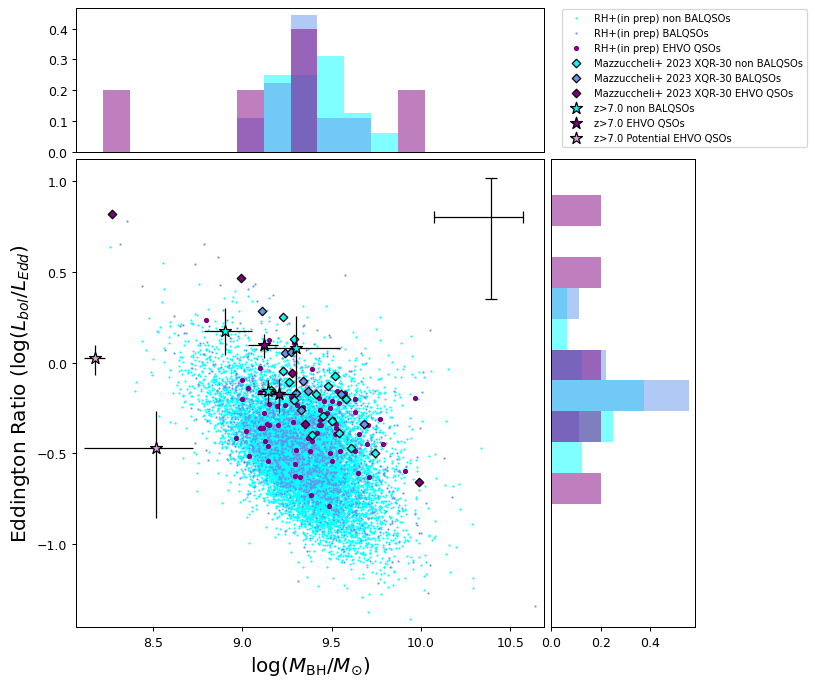

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

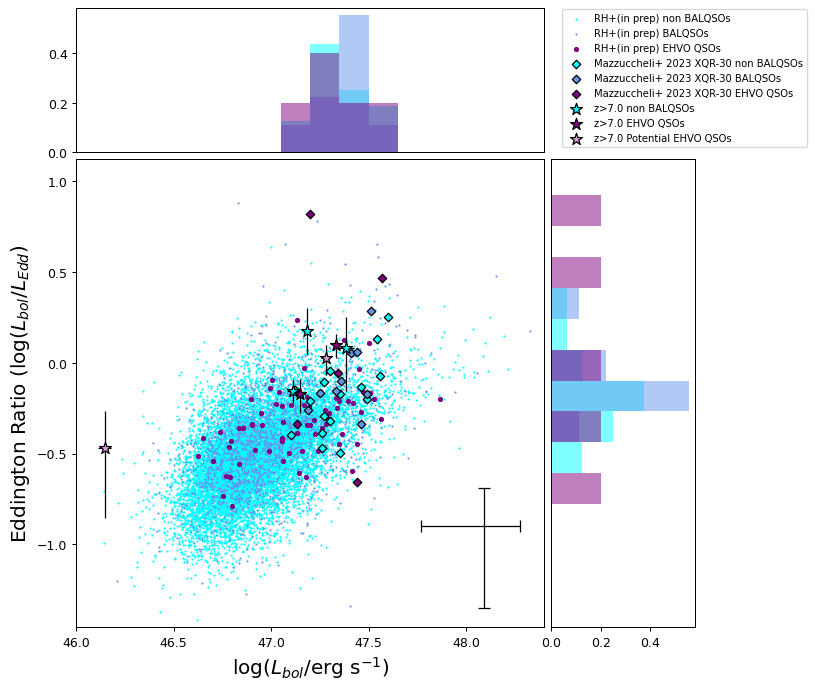

In [ ]:
#--------->THIS CELL IS FOR EDITING THE SPECIFIC PLOTS WE ARE USING FOR PRESENTATION<---------

bhm_vs_eddratio = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_MBH_Parent_zmid")
bhm_vs_eddratio.set_axes(xlabel="log($M_{\mathrm{BH}}/M_{\odot})$", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")
RH = 'y'
if RH == 'y':
  bhm_vs_eddratio.add_point(MBHnonBAL, ReddnonBAL, 'aqua', 'RH+(in prep) non BALQSOs', size = 0.5, addToHistogram=False)
  bhm_vs_eddratio.add_point(MBHBAL, ReddBAL, 'cornflowerblue', 'RH+(in prep) BALQSOs', size = 0.5, addToHistogram=False)
  bhm_vs_eddratio.add_point(MBH_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10, addToHistogram=False)
bhm_vs_eddratio.add_point(mbhmN, meddN, 'aqua', 'Mazzuccheli+ 2023 XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
bhm_vs_eddratio.add_point(mbhmB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
bhm_vs_eddratio.add_point(mbhmE, meddE, 'purple', 'Mazzuccheli+ 2023 XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')


for status in EHVO_STATUS:
  bhm_vs_eddratio.add_point(highZmass[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
  bhm_vs_eddratio.add_error(highZmass[status], highZedd[status], highZmassErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
bhm_vs_eddratio.add_error(ReferenceZero+10.39, ReferenceZero+0.805, xerr=[mbhmErrminus, mbhmErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize=5)
#bhm_vs_eddratio.add_point(ReferenceZero+100, ReferenceZero+100, 'black', 'Average error of XQR-30 Sample', marker='+', size = 100, addToHistogram=False, zorder=0.1)

if RH == 'y':
  bhm_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.7, MINUS_Y_SPACE=0.8, PLUS_Y_SPACE=0.3, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.572, 1.3315))
if RH == 'n':
  bhm_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.12)


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
lbol_vs_eddratio = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_Lbol_Parent_zmid")
lbol_vs_eddratio.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

if RH == 'y':
  lbol_vs_eddratio.add_point(LbolnonBAL, ReddnonBAL, 'aqua', 'RH+(in prep) non BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_eddratio.add_point(LbolBAL, ReddBAL, 'cornflowerblue', 'RH+(in prep) BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_eddratio.add_point(Lbol_EHVOR, Redd_EHVOR, 'purple', 'RH+(in prep) EHVO QSOs', size = 10, addToHistogram=False)
lbol_vs_eddratio.add_point(mlbolN, meddN, 'aqua', 'Mazzuccheli+ 2023 XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_eddratio.add_point(mlbolB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_eddratio.add_point(mlbolE, meddE, 'purple', 'Mazzuccheli+ 2023 XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')

for status in EHVO_STATUS:
  lbol_vs_eddratio.add_point(highZbol_lum[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
  lbol_vs_eddratio.add_error(highZbol_lum[status], highZedd[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

  #Average Error Point
lbol_vs_eddratio.add_error(ReferenceZero+48.09, ReferenceZero-0.9, xerr=[mlbolErrminus, mlbolErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize= 5)
#lbol_vs_eddratio.add_point(ReferenceZero+100, ReferenceZero-100, 'black', 'Average error of XQR-30 Sample', marker='+', size = 100, addToHistogram=False, zorder=0.1)
if RH == 'y':
  lbol_vs_eddratio.display_graph(MINUS_X_SPACE=1.1, PLUS_X_SPACE=0.8, MINUS_Y_SPACE=0.8, PLUS_Y_SPACE=0.3, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.572, 1.3315))

if RH == 'n':
  lbol_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1,  BINWIDTH_X = 0.05, BINWIDTH_Y=0.12)






<ipython-input-13-4e1bee71a85d>:179: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  invalidIndices = np.concatenate((idx, idy)).astype(np.signedinteger)


mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

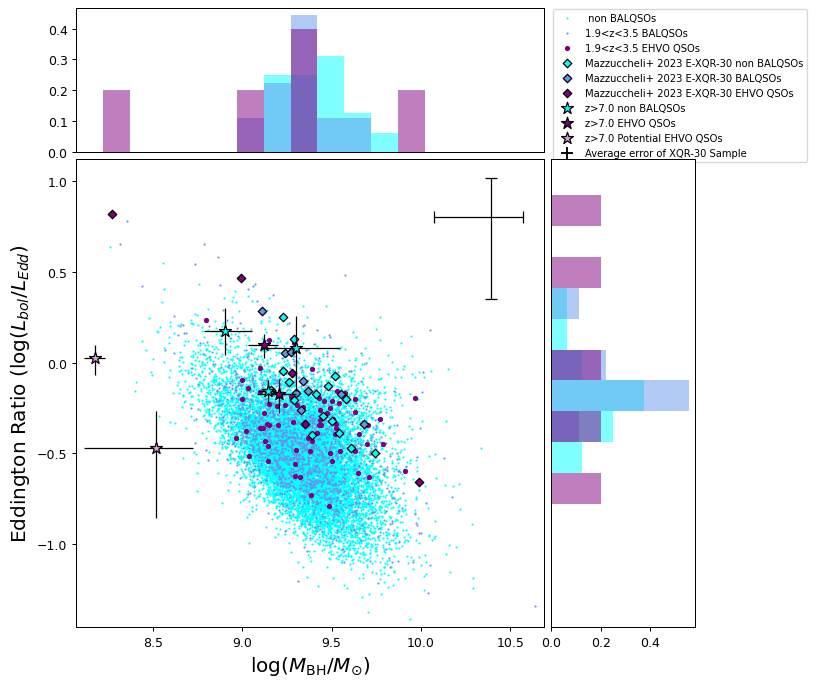

mkdir: cannot create directory ‘/content/drive/MyDrive/Images/’: File exists


<Figure size 576x432 with 0 Axes>

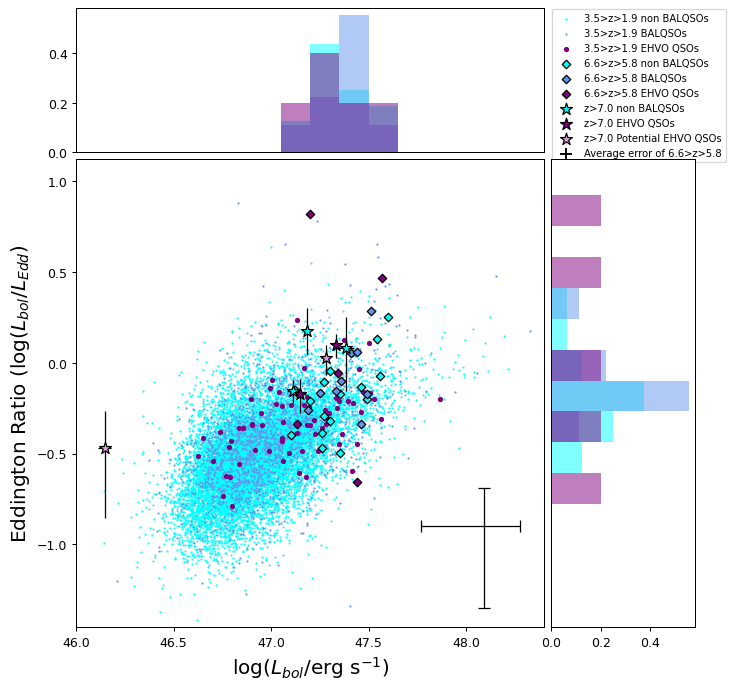

In [ ]:
bhm_vs_eddratio = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_MBH_Parent_zmid")
bhm_vs_eddratio.set_axes(xlabel="log($M_{\mathrm{BH}}/M_{\odot})$", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")
RH = 'y'
if RH == 'y':
  bhm_vs_eddratio.add_point(MBHnonBAL, ReddnonBAL, 'aqua', ' non BALQSOs', size = 0.5, addToHistogram=False)
  bhm_vs_eddratio.add_point(MBHBAL, ReddBAL, 'cornflowerblue', '1.9<z<3.5 BALQSOs', size = 0.5, addToHistogram=False)
  bhm_vs_eddratio.add_point(MBH_EHVOR, Redd_EHVOR, 'purple', '1.9<z<3.5 EHVO QSOs', size = 10, addToHistogram=False)
bhm_vs_eddratio.add_point(mbhmN, meddN, 'aqua', 'Mazzuccheli+ 2023 E-XQR-30 non BALQSOs', marker='D', size = 23, edgecolors='black')
bhm_vs_eddratio.add_point(mbhmB, meddB, 'cornflowerblue', 'Mazzuccheli+ 2023 E-XQR-30 BALQSOs', marker='D', size = 23, edgecolors='black')
bhm_vs_eddratio.add_point(mbhmE, meddE, 'purple', 'Mazzuccheli+ 2023 E-XQR-30 EHVO QSOs', marker='D', size = 23, edgecolors='black')


for status in EHVO_STATUS:
  bhm_vs_eddratio.add_point(highZmass[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
  bhm_vs_eddratio.add_error(highZmass[status], highZedd[status], highZmassErr[status], highZeddErr[status], ecolor=highZcolor[status])

#Average Error Point
bhm_vs_eddratio.add_error(ReferenceZero+10.39, ReferenceZero+0.805, xerr=[mbhmErrminus, mbhmErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize=5)
bhm_vs_eddratio.add_point(ReferenceZero+100, ReferenceZero+100, 'black', 'Average error of XQR-30 Sample', marker='+', size = 100, addToHistogram=False, zorder=0.1)

if RH == 'y':
  bhm_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.7, MINUS_Y_SPACE=0.8, PLUS_Y_SPACE=0.3, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.572, 1.3315))
if RH == 'n':
  bhm_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.12)


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
lbol_vs_eddratio = GraphHandler(0.1, 0.1, 0.65, 0.65, filename = "EddingtonRatio_vs_Lbol_Parent_zmid")
lbol_vs_eddratio.set_axes(xlabel="log($L_{bol}$/erg s$^{-1}$)", ylabel="Eddington Ratio (log($L_{bol}$/$L_{Edd}$)")

if RH == 'y':
  lbol_vs_eddratio.add_point(LbolnonBAL, ReddnonBAL, 'aqua', '3.5>z>1.9 non BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_eddratio.add_point(LbolBAL, ReddBAL, 'cornflowerblue', '3.5>z>1.9 BALQSOs', size = 0.5, addToHistogram=False)
  lbol_vs_eddratio.add_point(Lbol_EHVOR, Redd_EHVOR, 'purple', '3.5>z>1.9 EHVO QSOs', size = 10, addToHistogram=False)
lbol_vs_eddratio.add_point(mlbolN, meddN, 'aqua', '6.6>z>5.8 non BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_eddratio.add_point(mlbolB, meddB, 'cornflowerblue', '6.6>z>5.8 BALQSOs', marker='D', size = 23, edgecolors='black')
lbol_vs_eddratio.add_point(mlbolE, meddE, 'purple', '6.6>z>5.8 EHVO QSOs', marker='D', size = 23, edgecolors='black')

for status in EHVO_STATUS:
  lbol_vs_eddratio.add_point(highZbol_lum[status], highZedd[status], highZcolor[status], highZlabel[status], marker='*', size=100, addToHistogram=False, edgecolors='black', zorder=10)
  lbol_vs_eddratio.add_error(highZbol_lum[status], highZedd[status], highZbolErr[status], highZeddErr[status], ecolor=highZcolor[status])

  #Average Error Point
lbol_vs_eddratio.add_error(ReferenceZero+48.09, ReferenceZero-0.9, xerr=[mlbolErrminus, mlbolErrplus], yerr=[meddErrminus, meddErrplus], ecolor='red', capsize= 5)
lbol_vs_eddratio.add_point(ReferenceZero+100, ReferenceZero-100, 'black', 'Average error of 6.6>z>5.8', marker='+', size = 100, addToHistogram=False, zorder=0.1)
if RH == 'y':
  lbol_vs_eddratio.display_graph(MINUS_X_SPACE=1.1, PLUS_X_SPACE=0.8, MINUS_Y_SPACE=0.8, PLUS_Y_SPACE=0.3, BINWIDTH_X = VELOCITY_GRAPH_BINWIDTH_X, BINWIDTH_Y=0.17, bbox_to_anchor=(1.399, 1.3316))

if RH == 'n':
  lbol_vs_eddratio.display_graph(MINUS_X_SPACE=0.2, PLUS_X_SPACE=0.1, MINUS_Y_SPACE=0.1, PLUS_Y_SPACE=0.1,  BINWIDTH_X = 0.05, BINWIDTH_Y=0.12)